In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

In [ ]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            try:
              img = cv2.imread(img_path)
              img = cv2.resize(img, (image_size, image_size))
              X.append(img)
              Y.append(labels.index(label))
            except Exception as e:
              print(f"Error loading {img_name}: {e}")
    return np.array(X), np.array(Y)

In [ ]:
def display_random_images(X, Y, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])
        plt.title(labels[Y[idx]])
        plt.axis('off')
    plt.show()

# Example usage
labels = ['COVID-19', 'Pneumonia']
base_path = 'path_to_dataset'  # Replace with your dataset path
image_size = 224

X, Y = load_data(image_size, labels, base_path)
display_random_images(X, Y, labels, num_images=5)

In [ ]:
image_size = 150
labels = ['covid', 'pneumonia']
base_path = '/content/drive/MyDrive/covid_pneumonia'

# Load data
X, Y = load_data(image_size, labels, base_path)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

Error loading .ipynb_checkpoints: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
def build_and_train_model(base_model, X_train, Y_train, X_test, Y_test, labels, model_name):
    # Custom top layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=32),
                        epochs=10,
                        validation_data=(X_test, Y_test))
    training_time = time.time() - start_time

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model.save(f'lungultrasound_model_{model_name}.h5')

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
    class_report = classification_report(Y_test, Y_pred_classes, target_names=labels)

    print(f'Classification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return history, training_time, conf_matrix, class_report, Y_test, Y_pred_classes

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7781 - loss: 1.0378 - val_accuracy: 0.9192 - val_loss: 0.4018
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.9890 - loss: 0.0302 - val_accuracy: 0.9798 - val_loss: 0.1342
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9855 - loss: 0.1070 - val_accuracy: 0.9596 - val_loss: 0.3369
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.9944 - loss: 0.0129 - val_accuracy: 0.8990 - val_loss: 1.0184
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9909 - loss: 0.0259 - val_accuracy: 0.9596 - val_loss: 0.4462
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.9962 - loss: 0.0281 - val_accuracy: 0.8889 - val_loss: 1.0883
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.9987 - loss: 0.0022 - val_accuracy: 0.9495 - val_loss: 0.5532
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 

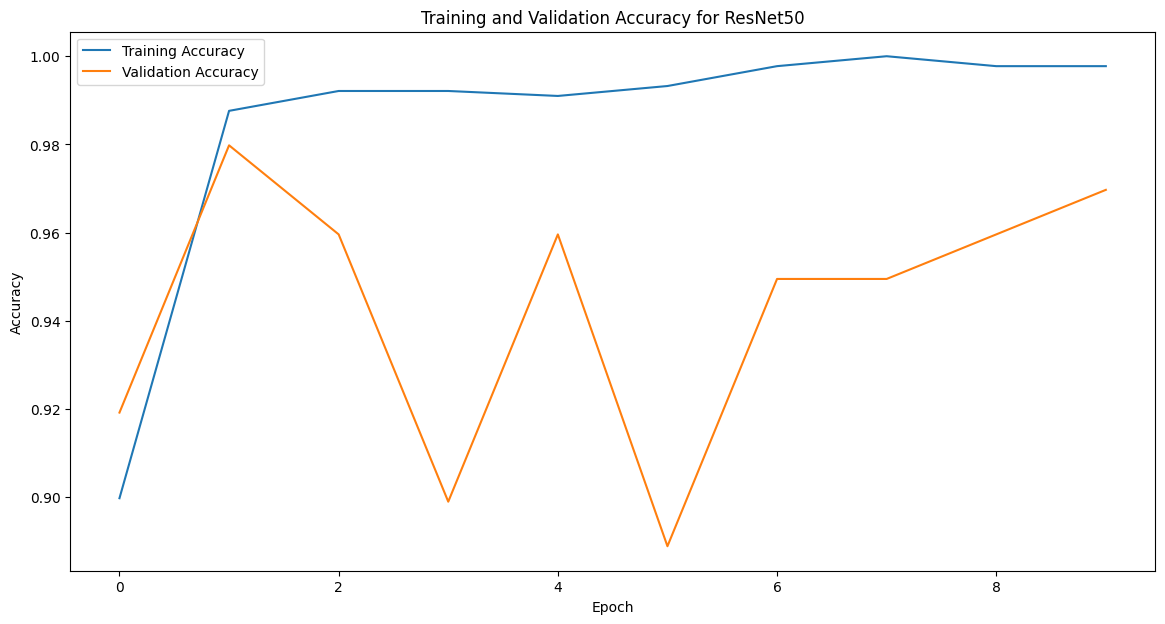

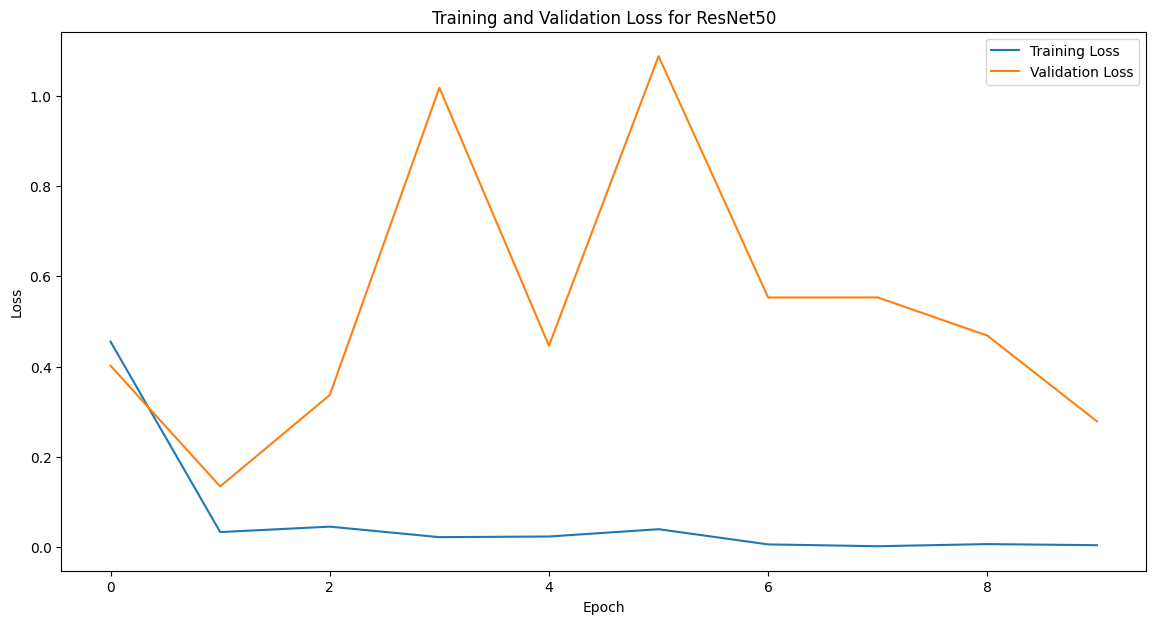

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

       covid       1.00      0.94      0.97        54
   pneumonia       0.94      1.00      0.97        45

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



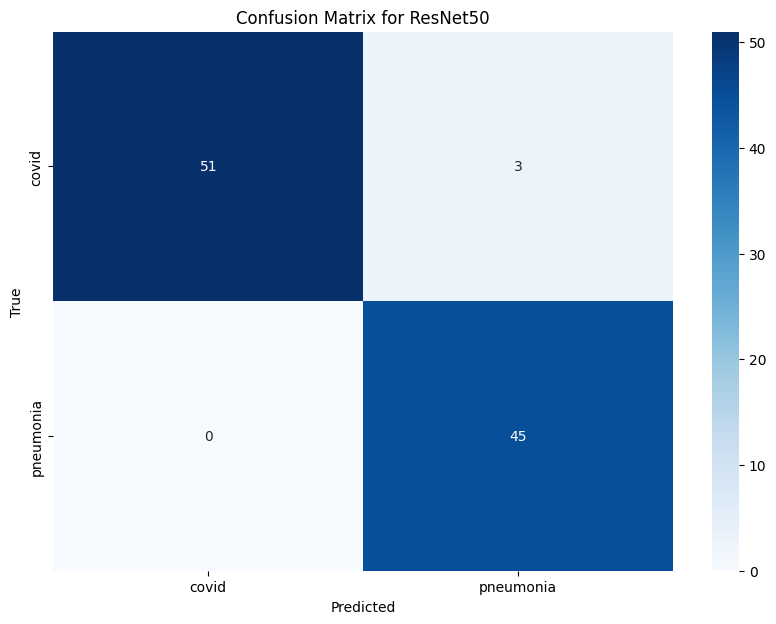

In [ ]:
# Train ResNet50 Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_test, Y_test, labels, 'ResNet50')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(f'lungultrasound_model_ResNet50.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

# Display results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step - accuracy: 0.9785 - loss: 0.1796
Test Loss: 0.2784
Test Accuracy: 96.97%


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/50
61/61 [==============================] - 42s 423ms/step - loss: 0.8572 - accuracy: 0.7130 - val_loss: 0.4229 - val_accuracy: 0.8837
Epoch 2/50
61/61 [==============================] - 16s 266ms/step - loss: 0.3724 - accuracy: 0.8516 - val_loss: 0.2326 - val_accuracy: 0.9070
Epoch 3/50
61/61 [==============================] - 16s 268ms/step - loss: 0.2378 - accuracy: 0.8981 - val_loss: 0.1158 - val_accuracy: 0.9628
Epoch 4/50
61/61 [==============================] - 16s 261ms/step - loss: 0.1862 - accuracy: 0.9307 - val_loss: 0.1409 - val_accuracy: 0.9581
Epoch 5/50
61/61 [==============================] - 16s 266ms/step - loss: 0.1846 - accuracy: 0.9385 - val_loss: 0.1033 - val_accuracy: 0.9581
Epoch 6/50
61/61 [==============================] - 16s 260ms/step - loss: 0.1201 - accuracy: 0.9592 - val_loss: 0.0578 - val_accuracy: 0.9767
Epoch 7/50
61/61 [==============================] - 16s 262ms/step - loss: 0.

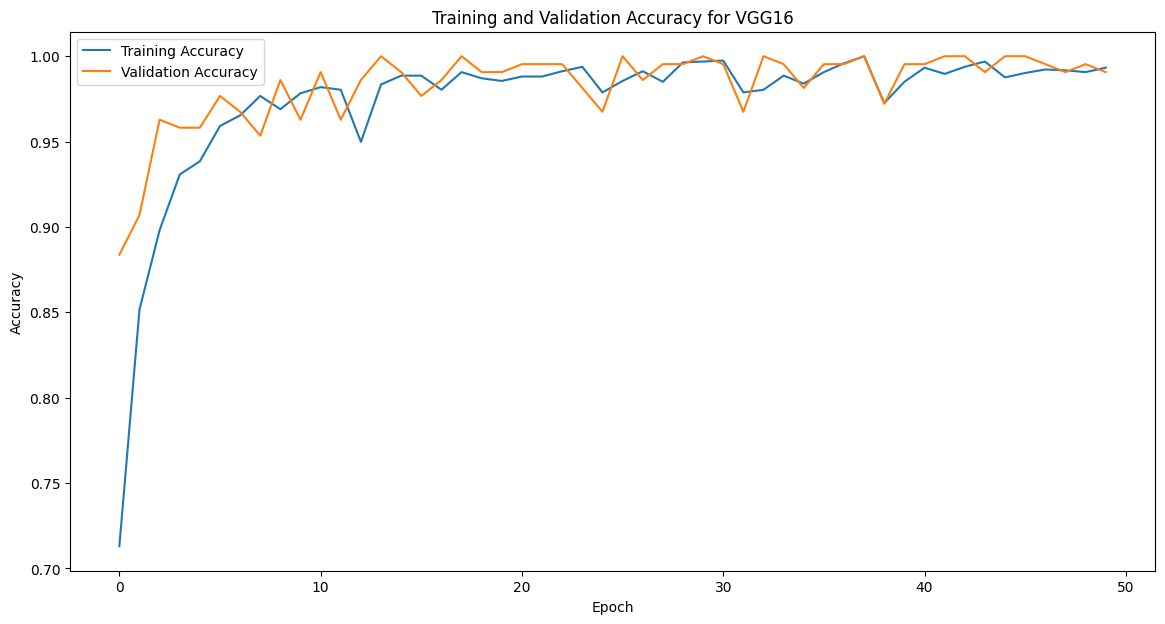

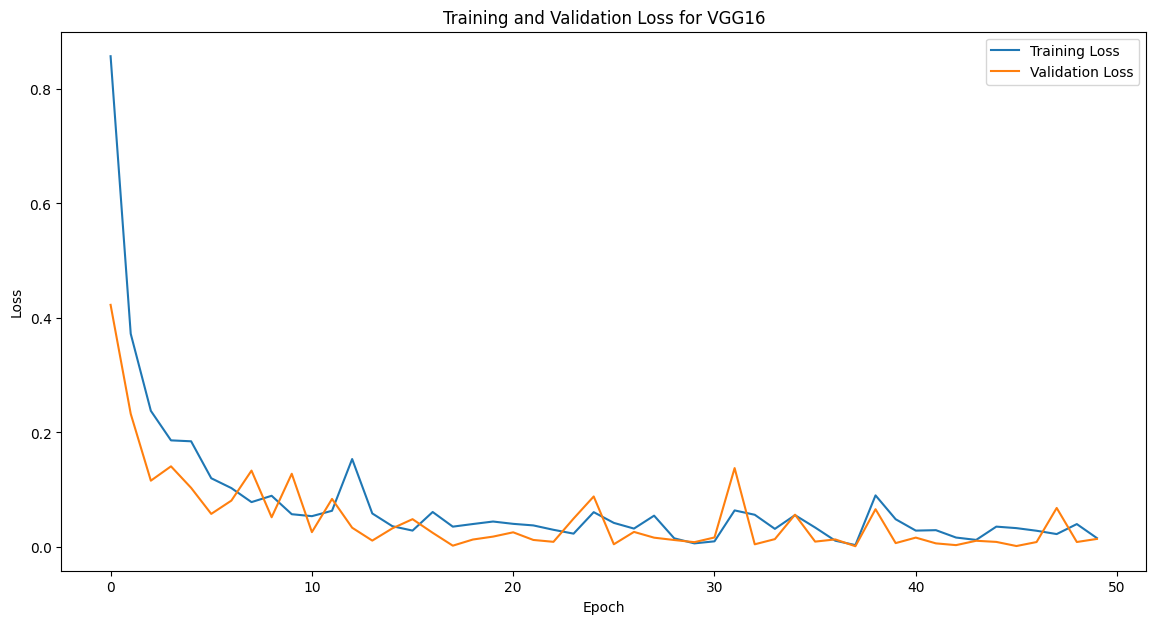

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 60ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        60
   pneumonia       1.00      0.95      0.98        44
     regular       0.98      1.00      0.99       111

    accuracy                           0.99       215
   macro avg       0.99      0.98      0.99       215
weighted avg       0.99      0.99      0.99       215



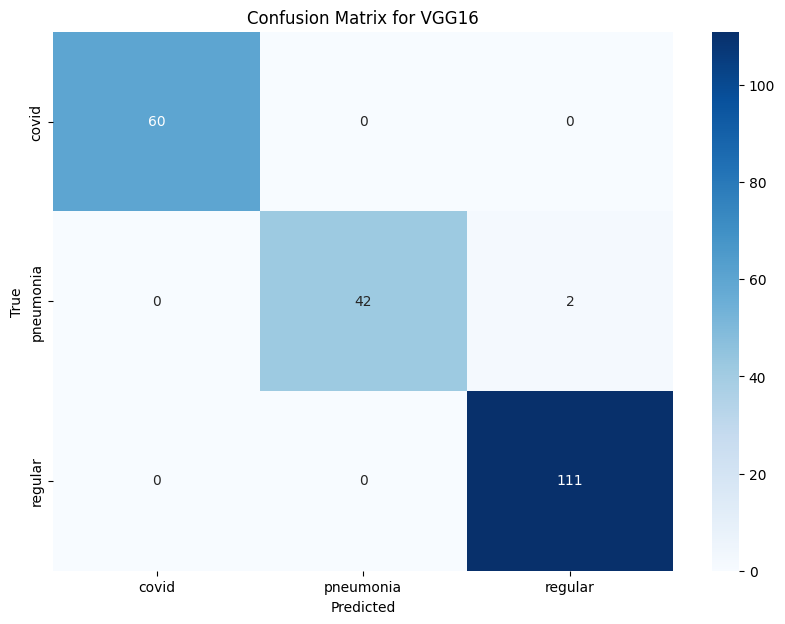

In [ ]:
# Train VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history_vgg, time_vgg, conf_matrix_vgg, report_vgg, Y_test_vgg, Y_pred_vgg = build_and_train_model(base_model_vgg, X_train, Y_train, X_test, Y_test, labels, 'VGG16')

In [ ]:
def calculate_metrics(conf_matrix, Y_test, Y_pred_classes):
    # Sensitivity (Recall)
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Specificity
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        specificity.append(true_negatives / (true_negatives + false_positives))

    # Cohen's Kappa
    kappa = cohen_kappa_score(Y_test, Y_pred_classes)

    # Classification Report (F1-score included)
    class_report_dict = classification_report(Y_test, Y_pred_classes, target_names=labels, output_dict=True)
    f1_score = {label: class_report_dict[label]['f1-score'] for label in labels}

    return sensitivity, specificity, f1_score, kappa

sensitivity_resnet, specificity_resnet, f1_score_resnet, kappa_resnet = calculate_metrics(conf_matrix_resnet, Y_test_resnet, Y_pred_resnet)
sensitivity_vgg, specificity_vgg, f1_score_vgg, kappa_vgg = calculate_metrics(conf_matrix_vgg, Y_test_vgg, Y_pred_vgg)

In [ ]:
print("ResNet50 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_resnet}")
print(f"Specificity: {specificity_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Cohen's Kappa: {kappa_resnet}")

print("\nVGG16 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_vgg}")
print(f"Specificity: {specificity_vgg}")
print(f"F1 Score: {f1_score_vgg}")
print(f"Cohen's Kappa: {kappa_vgg}")

ResNet50 Metrics:
Sensitivity (Recall): [1. 1. 1.]
Specificity: [1.0, 1.0, 1.0]
F1 Score: {'covid': 1.0, 'pneumonia': 1.0, 'regular': 1.0}
Cohen's Kappa: 1.0

VGG16 Metrics:
Sensitivity (Recall): [1.         0.95454545 1.        ]
Specificity: [1.0, 1.0, 0.9807692307692307]
F1 Score: {'covid': 1.0, 'pneumonia': 0.9767441860465117, 'regular': 0.9910714285714286}
Cohen's Kappa: 0.9847701352978678
